In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint"
sample_dir = "./out/zoom_NoAug_vanillaG_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


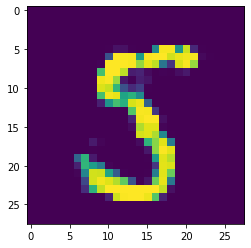

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder-tf.log(alpha)*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    
    if alpha == 1:
        return outputs_zs, mask_fn
    
    new_size = int(alpha*img_size)

    ## crop
    if alpha < 1:
        output_cropped = outputs_zs[:,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
        mask_cropped = mask_fn
    ## padding
    else:
        output_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        mask_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        output_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs 
        mask_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn
    
    ## Resize
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.resize(output_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.resize(mask_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        
    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
    
    if show_img:
        print('Target image:')
        imshow_unscaled(target_fn)
    if show_mask:
        print('Target mask:')
        imshow_unscaled(mask_out)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/zoom_NoAug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(0.6, 1.) 
            else:
                alpha_val = np.random.uniform(1., 1.67) 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-12 17:46:02,379 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.31171274185180664, 0, 0, 0.1890411525964737, 0.6472203579107133
2019-09-12 17:46:02,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005919218063354492, 0, 10, 0.13941769301891327, 1.3268087896318332
2019-09-12 17:46:02,391 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005517244338989258, 0, 20, 0.016815204173326492, 0.9815755022674948
2019-09-12 17:46:02,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005510568618774414, 0, 30, 0.23485064506530762, 0.6127145854473951
2019-09-12 17:46:02,404 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006028175354003906, 0, 40, 0.15551963448524475, 0.7252242541560228
2019-09-12 17:46:02,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005513191223144531, 0, 50, 0.14893554151058197, 1.4911149630515041
2019-09-12 17:46:02,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005368947982788086, 0, 60, 0.01791008561849594, 1.044392562618181
2019-09-12 17:46:02,422 [MainThread  

2019-09-12 17:46:02,761 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005145549774169922, 0, 600, 0.15484361350536346, 0.7805792434199624
2019-09-12 17:46:02,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005391359329223633, 0, 610, 0.06601379066705704, 0.8725510782455248
2019-09-12 17:46:02,774 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006348848342895508, 0, 620, 0.16787928342819214, 0.7048058712112911
2019-09-12 17:46:02,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057489871978759766, 0, 630, 0.09439939260482788, 1.3044461411665558
2019-09-12 17:46:02,788 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006610870361328125, 0, 640, 0.012524846009910107, 0.9858461789885951
2019-09-12 17:46:02,795 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006721973419189453, 0, 650, 0.03641968593001366, 1.1099296525861753
2019-09-12 17:46:02,803 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007066488265991211, 0, 660, 0.04324081540107727, 0.9138662271899038
2019-09-12 17:46:02,811 [

2019-09-12 17:46:03,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005719423294067383, 0, 1190, 0.1855926513671875, 0.6494968020849599
2019-09-12 17:46:03,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006170511245727539, 0, 1200, 0.08775968104600906, 0.8209370522163353
2019-09-12 17:46:03,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005864381790161133, 0, 1210, 0.2242283672094345, 0.6233572929166648
2019-09-12 17:46:03,427 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005975246429443359, 0, 1220, 0.11802159249782562, 1.57419737016607
2019-09-12 17:46:03,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006174325942993164, 0, 1230, 0.11114324629306793, 1.6439670463345952
2019-09-12 17:46:03,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006004810333251953, 0, 1240, 0.216238871216774, 0.6597351612040582
2019-09-12 17:46:03,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007424354553222656, 0, 1250, 0.04568622261285782, 1.2223871405048814
2019-09-12 17:46:03,456 [M

2019-09-12 17:46:03,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006305217742919922, 0, 1780, 0.19143101572990417, 0.6825605947284662
2019-09-12 17:46:03,864 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006656169891357422, 0, 1790, 0.11956597119569778, 0.7670089646136529
2019-09-12 17:46:03,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006177425384521484, 0, 1800, 0.04999961704015732, 0.863003781286829
2019-09-12 17:46:03,878 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006095409393310547, 0, 1810, 0.07804696261882782, 1.2959312969680306
2019-09-12 17:46:03,886 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006665945053100586, 0, 1820, 0.09429777413606644, 1.5373217599270532
2019-09-12 17:46:03,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067403316497802734, 0, 1830, 0.07960332185029984, 1.4848759173272734
2019-09-12 17:46:03,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006702899932861328, 0, 1840, 0.00030290891299955547, 1.0181279140914752
2019-09-12 17:46:

2019-09-12 17:46:04,282 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005501270294189453, 0, 2370, 0.029154865071177483, 1.16062100529957
2019-09-12 17:46:04,288 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00532078742980957, 0, 2380, 0.13940216600894928, 0.7578807457782717
2019-09-12 17:46:04,295 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057032108306884766, 0, 2390, 0.0908169224858284, 0.8391025818442462
2019-09-12 17:46:04,302 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006794452667236328, 0, 2400, 0.138999342918396, 0.726242052127309
2019-09-12 17:46:04,310 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006661176681518555, 0, 2410, 0.08734235912561417, 1.5049889813230697
2019-09-12 17:46:04,318 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007219076156616211, 0, 2420, 0.20818054676055908, 0.630782671093064
2019-09-12 17:46:04,325 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006453752517700195, 0, 2430, 0.18883517384529114, 0.6348548644030663
2019-09-12 17:46:04,333 [M

2019-09-12 17:46:04,728 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062901973724365234, 0, 2960, 0.06830943375825882, 1.300622902425551
2019-09-12 17:46:04,735 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062901973724365234, 0, 2970, 0.08256801217794418, 1.6279332821414385
2019-09-12 17:46:04,742 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006177663803100586, 0, 2980, 0.03165414184331894, 1.21838684135215
2019-09-12 17:46:04,749 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005992412567138672, 0, 2990, 0.09035377204418182, 1.623472387401799
2019-09-12 17:46:04,756 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006372690200805664, 0, 3000, 0.08410411328077316, 1.4902756859984794
Loss: [0.009976278197209467, 0.008551103179896017, 0.007183376112614951]
2019-09-12 17:46:04,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006192207336425781, 0, 3010, 0.21647778153419495, 0.6823107083641203
2019-09-12 17:46:04,771 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007143020629882812

2019-09-12 17:46:05,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009818315505981445, 0, 3550, 0.00026910408632829785, 1.0110567285457048
2019-09-12 17:46:05,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006428956985473633, 0, 3560, 0.0644383355975151, 1.331762254980815
2019-09-12 17:46:05,206 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060596466064453125, 0, 3570, 0.05638612061738968, 1.4392274630850426
2019-09-12 17:46:05,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006358623504638672, 0, 3580, 0.05511368066072464, 1.2621997278884716
2019-09-12 17:46:05,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006440877914428711, 0, 3590, 0.07441437989473343, 1.518592161030949
2019-09-12 17:46:05,227 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006312847137451172, 0, 3600, 0.07548239827156067, 1.4075108168474824
2019-09-12 17:46:05,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006758451461791992, 0, 3610, 0.15799947082996368, 0.7449700121582434
2019-09-12 17:46:05

2019-09-12 17:46:05,624 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006629228591918945, 0, 4130, 0.036967016756534576, 1.2196663370742467
2019-09-12 17:46:05,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005864620208740234, 0, 4140, 0.0779232308268547, 1.50958987368152
2019-09-12 17:46:05,638 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006432294845581055, 0, 4150, 0.034908637404441833, 0.9267693137041914
2019-09-12 17:46:05,646 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007675886154174805, 0, 4160, 0.03486955165863037, 0.8697373174475573
2019-09-12 17:46:05,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009268760681152344, 0, 4170, 0.05811980739235878, 1.3353575594734355
2019-09-12 17:46:05,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007801532745361328, 0, 4180, 0.19327124953269958, 0.6413212387522038
2019-09-12 17:46:05,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006817340850830078, 0, 4190, 0.056758955121040344, 1.3462179584814777
2019-09-12 17:46:05,

2019-09-12 17:46:06,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005166292190551758, 0, 4720, 0.05657896772027016, 1.2791075600160946
2019-09-12 17:46:06,043 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005204677581787109, 0, 4730, 0.11072643101215363, 0.7495060251505183
2019-09-12 17:46:06,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005368232727050781, 0, 4740, 0.09205291420221329, 0.7538428551147762
2019-09-12 17:46:06,055 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005201101303100586, 0, 4750, 0.10430575907230377, 1.6082168249793827
2019-09-12 17:46:06,061 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0050623416900634766, 0, 4760, 0.05524732172489166, 1.3058729905928228
2019-09-12 17:46:06,066 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00490260124206543, 0, 4770, 0.07623418420553207, 1.6189340601552482
2019-09-12 17:46:06,072 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005256175994873047, 0, 4780, 0.10011900961399078, 1.5729720063998287
2019-09-12 17:46:06,

2019-09-12 17:46:06,401 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005272388458251953, 0, 5300, 0.0019981819204986095, 1.0352541526873429
2019-09-12 17:46:06,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005363941192626953, 0, 5310, 0.11019638925790787, 0.7965791654267109
2019-09-12 17:46:06,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005038738250732422, 0, 5320, 0.01037132553756237, 1.099729477190416
2019-09-12 17:46:06,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0052678585052490234, 0, 5330, 0.15308809280395508, 0.7725187349123739
2019-09-12 17:46:06,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005457162857055664, 0, 5340, 0.025781521573662758, 1.1306259671099168
2019-09-12 17:46:06,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0048639774322509766, 0, 5350, 0.07259451597929001, 1.6011424843646798
2019-09-12 17:46:06,435 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00496363639831543, 0, 5360, 0.0721508339047432, 1.3022898694255645
2019-09-12 17:46:0

2019-09-12 17:46:06,768 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005312919616699219, 0, 5890, 0.08485705405473709, 1.6511849298136427
2019-09-12 17:46:06,776 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070459842681884766, 0, 5900, 0.050536151975393295, 1.439909820549671
2019-09-12 17:46:06,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009085655212402344, 0, 5910, 0.03256867453455925, 1.155436207552026
2019-09-12 17:46:06,794 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007502555847167969, 0, 5920, 0.01969466730952263, 1.0466410649925306
2019-09-12 17:46:06,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006261587142944336, 0, 5930, 0.018454816192388535, 0.9376869643370829
2019-09-12 17:46:06,808 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005856752395629883, 0, 5940, 0.0542704239487648, 1.259786461329175
2019-09-12 17:46:06,814 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005888223648071289, 0, 5950, 0.031746357679367065, 1.1254791507155084
2019-09-12 17:46:06,

2019-09-12 17:46:07,163 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0054874420166015625, 0, 6470, 0.04820714890956879, 1.4332216275230771
2019-09-12 17:46:07,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005217790603637695, 0, 6480, 0.07525519281625748, 0.7947297858042965
2019-09-12 17:46:07,175 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005979061126708984, 0, 6490, 0.0002067245077341795, 1.009986570802101
2019-09-12 17:46:07,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005246639251708984, 0, 6500, 0.03946623206138611, 0.8767363013901726
2019-09-12 17:46:07,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004971504211425781, 0, 6510, 0.06939536333084106, 1.5694843625521
2019-09-12 17:46:07,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005938291549682617, 0, 6520, 0.07516347616910934, 1.599656567755265
2019-09-12 17:46:07,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006924629211425781, 0, 6530, 0.08079615235328674, 1.6271120236225443
2019-09-12 17:46:07,20

2019-09-12 17:46:07,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006726503372192383, 0, 7050, 0.055248625576496124, 0.9042901014647206
2019-09-12 17:46:07,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008681297302246094, 0, 7060, 0.08885682374238968, 1.4400602420542912
2019-09-12 17:46:07,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006779670715332031, 0, 7070, 0.08477439731359482, 1.6397496112952021
2019-09-12 17:46:07,615 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007202625274658203, 0, 7080, 0.048619795590639114, 0.8654320348059331
2019-09-12 17:46:07,623 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064356327056884766, 0, 7090, 0.050168730318546295, 1.3661225258117047
2019-09-12 17:46:07,629 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006127595901489258, 0, 7100, 0.055139537900686264, 1.3218611620435035
2019-09-12 17:46:07,636 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00565791130065918, 0, 7110, 0.16932350397109985, 0.7031876504337815
2019-09-12 17:46

2019-09-12 17:46:08,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005754709243774414, 0, 7640, 0.027600418776273727, 1.1496917800406636
2019-09-12 17:46:08,032 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006036281585693359, 0, 7650, 0.10952461510896683, 0.8176436577182535
2019-09-12 17:46:08,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00565338134765625, 0, 7660, 0.024466542527079582, 1.045182133875549
2019-09-12 17:46:08,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005493640899658203, 0, 7670, 0.08642000705003738, 1.5983437680326316
2019-09-12 17:46:08,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006363630294799805, 0, 7680, 0.009649868123233318, 1.0742806990110012
2019-09-12 17:46:08,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006659746170043945, 0, 7690, 0.06247763708233833, 0.8442204738231082
2019-09-12 17:46:08,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058634281158447266, 0, 7700, 0.082640141248703, 1.6283518654256084
2019-09-12 17:46:08,

2019-09-12 17:46:08,381 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006021261215209961, 0, 8220, 0.03857864812016487, 0.8706764093561998
2019-09-12 17:46:08,388 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006415367126464844, 0, 8230, 0.046323396265506744, 1.3020431451002523
2019-09-12 17:46:08,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005751371383666992, 0, 8240, 0.07955251634120941, 1.3276815964227655
2019-09-12 17:46:08,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005366802215576172, 0, 8250, 0.030366836115717888, 0.9233345894496787
2019-09-12 17:46:08,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005532979965209961, 0, 8260, 0.050175998359918594, 1.381567728196289
2019-09-12 17:46:08,412 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00508427619934082, 0, 8270, 0.042298994958400726, 0.8596843420013269
2019-09-12 17:46:08,417 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00500798225402832, 0, 8280, 0.08676481992006302, 1.6630926294736406
2019-09-12 17:46:08

2019-09-12 17:46:08,749 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006027936935424805, 0, 8810, 0.12040560692548752, 0.7458513329699528
2019-09-12 17:46:08,756 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006602764129638672, 0, 8820, 0.06486747413873672, 1.3008978044298902
2019-09-12 17:46:08,764 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006467580795288086, 0, 8830, 0.09111008793115616, 0.8174550860824141
2019-09-12 17:46:08,772 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007100820541381836, 0, 8840, 0.01912950538098812, 1.1515749566211813
2019-09-12 17:46:08,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073566436767578125, 0, 8850, 0.04117661714553833, 1.2316800740019747
2019-09-12 17:46:08,787 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006569862365722656, 0, 8860, 0.01507360115647316, 0.959442323645465
2019-09-12 17:46:08,795 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007143259048461914, 0, 8870, 0.06912918388843536, 1.3997870787229059
2019-09-12 17:46:08,

2019-09-12 17:46:09,163 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0047609806060791016, 0, 9380, 0.012499102391302586, 0.971588249489391
2019-09-12 17:46:09,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0051860809326171875, 0, 9390, 0.010142925195395947, 1.081485016776088
2019-09-12 17:46:09,175 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004990816116333008, 0, 9400, 0.03522510826587677, 0.8699743867952445
2019-09-12 17:46:09,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005259275436401367, 0, 9410, 0.05066272243857384, 1.2637268898024692
2019-09-12 17:46:09,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005379199981689453, 0, 9420, 0.06330250203609467, 1.2925714109611066
2019-09-12 17:46:09,193 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00549626350402832, 0, 9430, 0.22961898148059845, 0.6971613560490484
2019-09-12 17:46:09,200 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006515026092529297, 0, 9440, 0.025987686589360237, 1.111183370625506
2019-09-12 17:46:09

2019-09-12 17:46:09,535 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005815029144287109, 0, 9970, 0.06444298475980759, 0.8747939034412313
2019-09-12 17:46:09,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.004784345626831055, 0, 9980, 0.033477213233709335, 0.9178056621467467
2019-09-12 17:46:09,545 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005149126052856445, 0, 9990, 0.036300770938396454, 1.1210947651218552
2019-09-12 17:46:09,551 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005017757415771484, 0, 10000, 0.016464341431856155, 1.1534027857656668
Loss: [0.009976278197209467, 0.008551103179896017, 0.007183376112614951, 0.008202721576497424, 0.007235235102933075, 0.008330194210051559, 0.00757064858416561, 0.007485253460763488, 0.007196008362956491, 0.007055317130816547]
2019-09-12 17:46:09,557 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005442619323730469, 0, 10010, 0.1920490562915802, 0.7042576040210738
2019-09-12 17:46:09,563 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0

2019-09-12 17:46:09,900 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059201717376708984, 0, 10540, 0.0300158504396677, 0.8895450905411606
2019-09-12 17:46:09,907 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005781412124633789, 0, 10550, 0.0247176680713892, 1.142545148554237
2019-09-12 17:46:09,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005405426025390625, 0, 10560, 0.012744973413646221, 0.9602739769981945
2019-09-12 17:46:09,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005259513854980469, 0, 10570, 0.01296650804579258, 0.9764458001906086
2019-09-12 17:46:09,925 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005704402923583984, 0, 10580, 0.04140283167362213, 0.9125847798656714
2019-09-12 17:46:09,932 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006350994110107422, 0, 10590, 0.08891886472702026, 0.7978889537759879
2019-09-12 17:46:09,940 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007695674896240234, 0, 10600, 0.18197952210903168, 0.7118446769699545
2019-09-12 17:

2019-09-12 17:46:10,295 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006090641021728516, 0, 11110, 0.03474501147866249, 0.9018253051492283
2019-09-12 17:46:10,301 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005687236785888672, 0, 11120, 0.09102141112089157, 1.639533620874251
2019-09-12 17:46:10,307 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057523250579833984, 0, 11130, 0.041787322610616684, 1.2404174397464107
2019-09-12 17:46:10,316 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008405923843383789, 0, 11140, 0.06795254349708557, 1.4842022466914495
2019-09-12 17:46:10,327 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009176254272460938, 0, 11150, 0.040966570377349854, 1.2370667132687552
2019-09-12 17:46:10,340 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012347221374511719, 0, 11160, 0.061253421008586884, 0.850165034291215
2019-09-12 17:46:10,352 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010846614837646484, 0, 11170, 0.0992230772972107, 0.755320057847251
2019-09-12 17

2019-09-12 17:46:10,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005368947982788086, 0, 11700, 0.09601005911827087, 0.8515129865528007
2019-09-12 17:46:10,705 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005769014358520508, 0, 11710, 0.07259001582860947, 1.5901898844087032
2019-09-12 17:46:10,713 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006722450256347656, 0, 11720, 0.10572689026594162, 0.728022805119088
2019-09-12 17:46:10,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005676746368408203, 0, 11730, 0.08232460170984268, 1.607413813069246
2019-09-12 17:46:10,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057659149169921875, 0, 11740, 0.04363461956381798, 1.286940804026792
2019-09-12 17:46:10,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00544285774230957, 0, 11750, 0.01075893547385931, 0.9561674697426542
2019-09-12 17:46:10,738 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005452156066894531, 0, 11760, 0.04299239441752434, 0.8966629570182516
2019-09-12 17:46

2019-09-12 17:46:11,090 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006159305572509766, 0, 12270, 0.07012419402599335, 0.8051958488750606
2019-09-12 17:46:11,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010582208633422852, 0, 12280, 0.014455284923315048, 0.9873316324262
2019-09-12 17:46:11,113 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010984659194946289, 0, 12290, 0.07394226640462875, 1.5513577284155557
2019-09-12 17:46:11,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006560564041137695, 0, 12300, 0.0012706021079793572, 1.0295601728481687
2019-09-12 17:46:11,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005696535110473633, 0, 12310, 0.027009237557649612, 1.1141551367448654
2019-09-12 17:46:11,133 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005918979644775391, 0, 12320, 0.04120667278766632, 0.9156512134265
2019-09-12 17:46:11,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006052970886230469, 0, 12330, 0.042363159358501434, 1.2183236146683323
2019-09-12 17:

2019-09-12 17:46:11,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006212472915649414, 0, 12860, 0.1475018858909607, 0.733329893276724
2019-09-12 17:46:11,543 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006575107574462891, 0, 12870, 0.1611064374446869, 0.7765901311063912
2019-09-12 17:46:11,550 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063457489013671875, 0, 12880, 0.07737091928720474, 0.8556835304108448
2019-09-12 17:46:11,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007435321807861328, 0, 12890, 0.1708018183708191, 0.750702305286841
2019-09-12 17:46:11,566 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00659489631652832, 0, 12900, 0.049370668828487396, 0.9220143512736279
2019-09-12 17:46:11,573 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006279468536376953, 0, 12910, 0.03738783299922943, 0.9065824938072643
2019-09-12 17:46:11,581 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007056474685668945, 0, 12920, 0.020976463332772255, 1.1589944467898412
2019-09-12 17:46

2019-09-12 17:46:11,955 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011336565017700195, 0, 13430, 0.11374402046203613, 0.7251112929018722
2019-09-12 17:46:11,962 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006651401519775391, 0, 13440, 0.08383860439062119, 0.8148343786082265
2019-09-12 17:46:11,971 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008008956909179688, 0, 13450, 0.1795833706855774, 0.6791212036343781
2019-09-12 17:46:11,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071485042572021484, 0, 13460, 0.06649843603372574, 1.4233116768144125
2019-09-12 17:46:11,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006765842437744141, 0, 13470, 0.019429640844464302, 1.0688768591914477
2019-09-12 17:46:11,996 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862495422363281, 0, 13480, 0.0680966004729271, 1.6059110466162507
2019-09-12 17:46:12,004 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006937265396118164, 0, 13490, 0.05379828065633774, 1.2856996346210172
2019-09-12 17

2019-09-12 17:46:12,378 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005873918533325195, 0, 14010, 0.023999029770493507, 1.1101692351755434
2019-09-12 17:46:12,384 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005765438079833984, 0, 14020, 0.14080452919006348, 0.7188462657877146
2019-09-12 17:46:12,391 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00592494010925293, 0, 14030, 0.08310716599225998, 1.6491320059127779
2019-09-12 17:46:12,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006103515625, 0, 14040, 0.13744781911373138, 0.686543184534852
2019-09-12 17:46:12,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006209135055541992, 0, 14050, 0.022020097821950912, 1.0663057823115043
2019-09-12 17:46:12,412 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005898475646972656, 0, 14060, 0.0421321801841259, 0.8791233030399572
2019-09-12 17:46:12,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005796909332275391, 0, 14070, 0.053298819810152054, 1.5047976537637235
2019-09-12 17:46:12

2019-09-12 17:46:12,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005475282669067383, 0, 14600, 0.0702832043170929, 0.8424641719533109
2019-09-12 17:46:12,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005114078521728516, 0, 14610, 0.06443340331315994, 0.8047628927245934
2019-09-12 17:46:12,803 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0056362152099609375, 0, 14620, 0.079048290848732, 1.495172908793223
2019-09-12 17:46:12,810 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059125423431396484, 0, 14630, 0.034675415605306625, 0.9259397159226271
2019-09-12 17:46:12,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005565166473388672, 0, 14640, 0.027318457141518593, 1.1293931213487782
2019-09-12 17:46:12,823 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00639653205871582, 0, 14650, 0.06880050897598267, 0.7866440308051068
2019-09-12 17:46:12,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005322694778442383, 0, 14660, 0.19684788584709167, 0.652370621471059
2019-09-12 17:4

2019-09-12 17:46:13,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006412029266357422, 0, 15160, 0.010581210255622864, 1.086655817127034
2019-09-12 17:46:13,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006291627883911133, 0, 15170, 0.05543963611125946, 1.5187859321828667
2019-09-12 17:46:13,205 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006196498870849609, 0, 15180, 0.2054150551557541, 0.6114684959893075
2019-09-12 17:46:13,212 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005666971206665039, 0, 15190, 0.014779206365346909, 0.9492421386408119
2019-09-12 17:46:13,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006794929504394531, 0, 15200, 0.04056097939610481, 1.370124501038106
2019-09-12 17:46:13,227 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006318807601928711, 0, 15210, 0.02397322840988636, 1.1196762481891767
2019-09-12 17:46:13,233 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006144523620605469, 0, 15220, 0.015892399474978447, 0.9767666890918052
2019-09-12 17

2019-09-12 17:46:13,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010730504989624023, 0, 15750, 0.24423916637897491, 0.6357574335441697
2019-09-12 17:46:13,640 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007768392562866211, 0, 15760, 0.07200527936220169, 1.6641089370143587
2019-09-12 17:46:13,647 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062160491943359375, 0, 15770, 0.04088688641786575, 0.8832808079333674
2019-09-12 17:46:13,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005069255828857422, 0, 15780, 0.12590853869915009, 0.7414663471651854
2019-09-12 17:46:13,658 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005260467529296875, 0, 15790, 0.13178272545337677, 0.6441937579004167
2019-09-12 17:46:13,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005659818649291992, 0, 15800, 0.26273617148399353, 0.6008594290597034
2019-09-12 17:46:13,670 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005385875701904297, 0, 15810, 0.043375711888074875, 0.8747831789555616
2019-09-12 

2019-09-12 17:46:14,041 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006724119186401367, 0, 16310, 0.1069846972823143, 0.8357745949270571
2019-09-12 17:46:14,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007073879241943359, 0, 16320, 0.052871543914079666, 1.3588895515367574
2019-09-12 17:46:14,057 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007090091705322266, 0, 16330, 0.07975058257579803, 0.8108042069588237
2019-09-12 17:46:14,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072786808013916016, 0, 16340, 0.07560563087463379, 1.4447171965713823
2019-09-12 17:46:14,073 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070037841796875, 0, 16350, 0.08237365633249283, 1.4698919251433407
2019-09-12 17:46:14,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006990909576416016, 0, 16360, 0.12191713601350784, 0.7153132138319113
2019-09-12 17:46:14,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007262229919433594, 0, 16370, 0.06817235052585602, 1.525360508594339
2019-09-12 17:4

2019-09-12 17:46:14,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010000228881835938, 0, 16900, 0.18223291635513306, 0.6908318694763249
2019-09-12 17:46:14,510 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00577235221862793, 0, 16910, 0.0613870695233345, 1.501556858995468
2019-09-12 17:46:14,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006293058395385742, 0, 16920, 0.07430192083120346, 0.8449618834515193
2019-09-12 17:46:14,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005706071853637695, 0, 16930, 0.036734092980623245, 0.8945963834390109
2019-09-12 17:46:14,530 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006004810333251953, 0, 16940, 0.03737989068031311, 1.2096043919032349
2019-09-12 17:46:14,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0055429935455322266, 0, 16950, 0.13791829347610474, 0.7520019319592794
2019-09-12 17:46:14,542 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005188941955566406, 0, 16960, 0.05461636930704117, 1.5131473773201767
2019-09-12 17:

2019-09-12 17:46:14,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008305549621582031, 0, 17460, 0.16357946395874023, 0.609385784471901
2019-09-12 17:46:14,919 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007086992263793945, 0, 17470, 0.07289979606866837, 1.4215581364946293
2019-09-12 17:46:14,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00905919075012207, 0, 17480, 0.0522148534655571, 1.2844383239782213
2019-09-12 17:46:14,940 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009711742401123047, 0, 17490, 0.03095986135303974, 1.2444407575447813
2019-09-12 17:46:14,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008719444274902344, 0, 17500, 0.001585255260579288, 1.0350781146409822
2019-09-12 17:46:14,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009213447570800781, 0, 17510, 0.03858114406466484, 0.8676753830106884
2019-09-12 17:46:14,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007938861846923828, 0, 17520, 0.06352729350328445, 1.3670651187164462
2019-09-12 17:4

2019-09-12 17:46:15,357 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00944828987121582, 0, 18020, 0.012932938523590565, 0.9828252475115328
2019-09-12 17:46:15,365 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00728607177734375, 0, 18030, 0.039561882615089417, 0.8669097452453615
2019-09-12 17:46:15,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007178306579589844, 0, 18040, 0.09038179367780685, 0.8154854087518951
2019-09-12 17:46:15,382 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007519245147705078, 0, 18050, 0.054222472012043, 1.3198347456090285
2019-09-12 17:46:15,391 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007954597473144531, 0, 18060, 0.10250478982925415, 0.7774286583182165
2019-09-12 17:46:15,399 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007505893707275391, 0, 18070, 0.012430677190423012, 0.9301337752208584
2019-09-12 17:46:15,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006118059158325195, 0, 18080, 0.01271839626133442, 0.9956379102622487
2019-09-12 17:

2019-09-12 17:46:15,831 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064237117767333984, 0, 18610, 0.04060665890574455, 0.8777040924754804
2019-09-12 17:46:15,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005663394927978516, 0, 18620, 0.0865977481007576, 1.5206605724987843
2019-09-12 17:46:15,845 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006356239318847656, 0, 18630, 0.037882644683122635, 0.8800538613548052
2019-09-12 17:46:15,852 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00660252571105957, 0, 18640, 0.06662342697381973, 1.2773625906960608
2019-09-12 17:46:15,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060231685638427734, 0, 18650, 0.12793971598148346, 0.749946304588951
2019-09-12 17:46:15,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006272554397583008, 0, 18660, 0.00026120810071006417, 1.0127355585996116
2019-09-12 17:46:15,873 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006980180740356445, 0, 18670, 0.16961972415447235, 0.6616489969903419
2019-09-12

2019-09-12 17:46:16,231 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006538867950439453, 0, 19170, 0.057577211409807205, 1.3774197259692045
2019-09-12 17:46:16,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006943941116333008, 0, 19180, 0.08371235430240631, 1.432515532231288
2019-09-12 17:46:16,246 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060291290283203125, 0, 19190, 0.04206319898366928, 0.8840952858521685
2019-09-12 17:46:16,253 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006418704986572266, 0, 19200, 4.039188570459373e-05, 1.004642961689784
2019-09-12 17:46:16,260 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005827903747558594, 0, 19210, 0.06049094349145889, 1.4562284845498203
2019-09-12 17:46:16,267 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00613093376159668, 0, 19220, 0.05991191789507866, 0.8401710415430179
2019-09-12 17:46:16,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058689117431640625, 0, 19230, 0.13179627060890198, 0.7276159489444829
2019-09-12 

2019-09-12 17:46:16,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006308078765869141, 0, 19760, 0.2000880092382431, 0.6017239392515533
2019-09-12 17:46:16,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006329059600830078, 0, 19770, 0.10240716487169266, 0.7197665362075096
2019-09-12 17:46:16,678 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006018161773681641, 0, 19780, 0.16458073258399963, 0.6873192942758877
2019-09-12 17:46:16,685 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00586700439453125, 0, 19790, 0.05211316794157028, 1.2905027642191895
2019-09-12 17:46:16,692 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006556272506713867, 0, 19800, 0.011482983827590942, 0.9392989043529363
2019-09-12 17:46:16,699 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006273508071899414, 0, 19810, 0.01293844822794199, 0.9932125594940419
2019-09-12 17:46:16,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058422088623046875, 0, 19820, 0.18898212909698486, 0.6529754798711928
2019-09-12 17

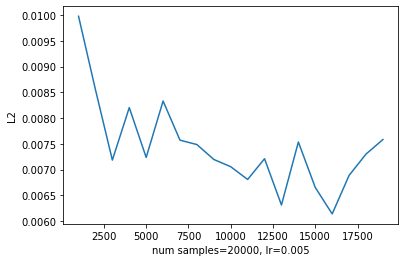

[0.009976278197209467, 0.008551103179896017, 0.007183376112614951, 0.008202721576497424, 0.007235235102933075, 0.008330194210051559, 0.00757064858416561, 0.007485253460763488, 0.007196008362956491, 0.007055317130816547, 0.006807470472936984, 0.0072103917196800465, 0.006312060813846074, 0.007534340166777838, 0.006651979396527168, 0.006138839205956174, 0.006886317077376589, 0.00730019309603631, 0.007582462133897934]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[0.5        0.55555556 0.625      0.71428571 0.83333333 1.
 1.2        1.4        1.6        1.8        2.        ]


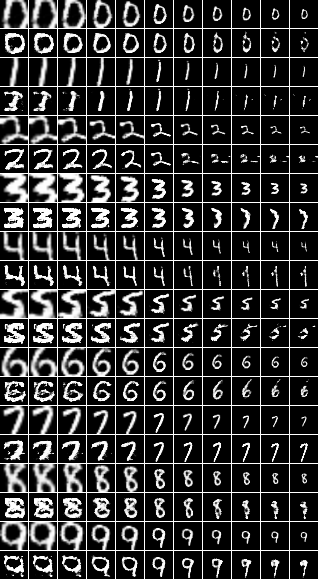

In [16]:
num_samples = 10

a = np.array([1.2, 1.4, 1.6, 1.8, 2.])
np.reciprocal(a[::-1])
b=[np.reciprocal(a[::-1]),np.array([1]),a]
a = np.concatenate(b)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 200
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained
# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [29]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -0.64, dist 0.01 +/- 0.01
alpha: -0.53, dist 0.02 +/- 0.01
alpha: -0.40, dist 0.02 +/- 0.01
alpha: -0.26, dist 0.03 +/- 0.01
alpha: -0.09, dist 0.04 +/- 0.02
alpha: 0.09, dist 0.03 +/- 0.02
alpha: 0.26, dist 0.02 +/- 0.01
alpha: 0.40, dist 0.01 +/- 0.01
alpha: 0.53, dist 0.01 +/- 0.01
alpha: 0.64, dist 0.00 +/- 0.00


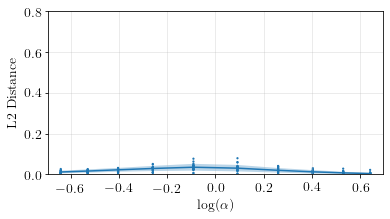

In [30]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_NoAug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -0.69, dist 0.25 +/- 0.02
alpha: -0.59, dist 0.24 +/- 0.02
alpha: -0.47, dist 0.20 +/- 0.02
alpha: -0.34, dist 0.12 +/- 0.01
alpha: -0.18, dist 0.07 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 0.18, dist 0.04 +/- 0.00
alpha: 0.34, dist 0.06 +/- 0.01
alpha: 0.47, dist 0.07 +/- 0.01
alpha: 0.59, dist 0.08 +/- 0.01
alpha: 0.69, dist 0.10 +/- 0.01


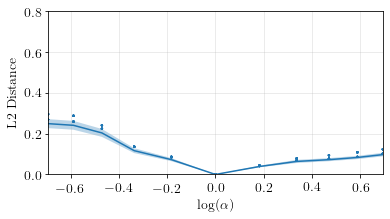

In [31]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_NoAug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)